# Analisis Prediktif Kecelakaan Lalu Lintas di India

Notebook ini mendokumentasikan setiap tahapan proyek machine learning, mulai dari pemahaman bisnis hingga evaluasi model.


## 1. Import Libraries

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.preprocessing import OneHotEncoder, MinMaxScaler
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer

from sklearn.linear_model import LogisticRegression, LinearRegression
from sklearn.ensemble import RandomForestClassifier, GradientBoostingRegressor
from xgboost import XGBClassifier
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score
from sklearn.metrics import mean_squared_error, r2_score


## 2. Data Understanding
Load dataset dan lihat beberapa baris pertama.

In [5]:
# Load dataset
df = pd.read_csv('./accident_prediction_india.csv')

# Tampilkan 5 baris pertama
df.head()


,State Name,City Name,Year,Month,Day of Week,Time of Day,Accident Severity,Number of Vehicles Involved,Vehicle Type Involved,Number of Casualties,...,Road Type,Road Condition,Lighting Conditions,Traffic Control Presence,Speed Limit (km/h),Driver Age,Driver Gender,Driver License Status,Alcohol Involvement,Accident Location Details
0,Jammu and Kashmir,Unknown,2021,May,Monday,1:46,Serious,5,Cycle,0,...,National Highway,Wet,Dark,Signs,61,66,Male,NaN,Yes,Curve
1,Uttar Pradesh,Lucknow,2018,January,Wednesday,21:30,Minor,5,Truck,5,...,Urban Road,Dry,Dusk,Signs,92,60,Male,NaN,Yes,Straight Road
2,Chhattisgarh,Unknown,2023,May,Wednesday,5:37,Minor,5,Pedestrian,6,...,National Highway,Under Construction,Dawn,Signs,120,26,Female,NaN,No,Bridge
3,Uttar Pradesh,Lucknow,2020,June,Saturday,0:31,Minor,3,Bus,10,...,State Highway,Dry,Dark,Signals,76,34,Female,Valid,Yes,Straight Road
4,Sikkim,Unknown,2021,August,Thursday,11:21,Minor,5,Cycle,7,...,Urban Road,Wet,Dusk,Signs,115,30,Male,NaN,No,Intersection


## 3. Exploratory Data Analysis
Analisis distribusi dan korelasi data.

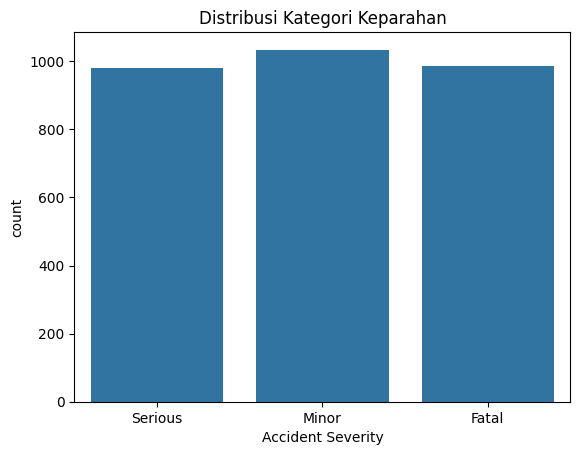

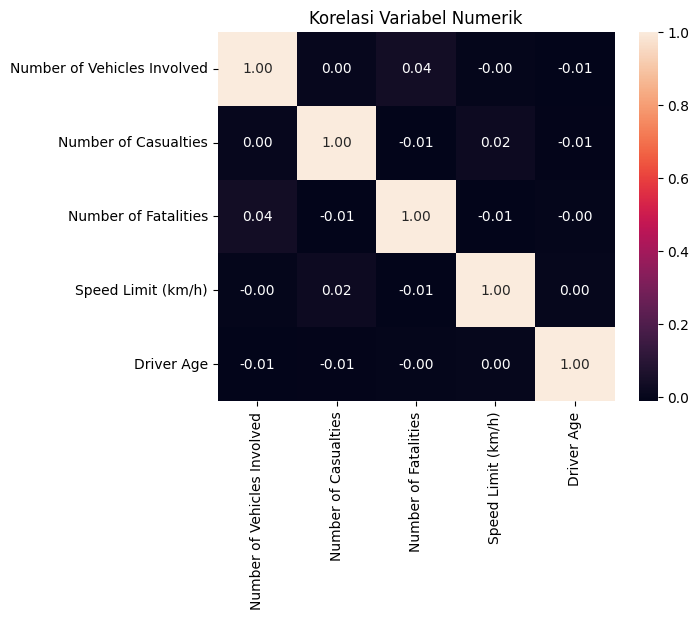

In [6]:
# Distribusi target 'Accident Severity'
sns.countplot(data=df, x='Accident Severity')
plt.title('Distribusi Kategori Keparahan')
plt.show()

# Korelasi numerik
numeric_cols = ['Number of Vehicles Involved', 'Number of Casualties', 'Number of Fatalities', 'Speed Limit (km/h)', 'Driver Age']
corr = df[numeric_cols].corr()
sns.heatmap(corr, annot=True, fmt='.2f')
plt.title('Korelasi Variabel Numerik')
plt.show()


## 4. Data Preparation
- Pembersihan data
- Encoding kategorikal
- Feature engineering
- Normalisasi
- Split data

In [7]:
# 4.1 Pembersihan dan imputasi
df_clean = df.copy()
# Imputasi nilai hilang
imputer = SimpleImputer(strategy='most_frequent')
df_clean[['City Name']] = imputer.fit_transform(df_clean[['City Name']])

# 4.2 Feature Engineering
# Rush Hour
def rush_hour(time_str):
    h = int(time_str.split(':')[0])
    return 1 if (7 <= h <= 9) or (17 <= h <= 19) else 0

df_clean['Rush Hour'] = df_clean['Time of Day'].apply(rush_hour)

# 4.3 Split features dan target
X_cls = df_clean.drop(['Accident Severity', 'Number of Fatalities'], axis=1)
y_cls = df_clean['Accident Severity']

X_reg = df_clean.drop(['Number of Fatalities'], axis=1)
y_reg = df_clean['Number of Fatalities']

# 4.4 Train-test split
X_train_cls, X_test_cls, y_train_cls, y_test_cls = train_test_split(X_cls, y_cls, test_size=0.3, random_state=42)
X_train_reg, X_test_reg, y_train_reg, y_test_reg = train_test_split(X_reg, y_reg, test_size=0.3, random_state=42)

# 4.5 Preprocessing pipelines
numeric_features = ['Number of Vehicles Involved', 'Number of Casualties', 'Speed Limit (km/h)', 'Driver Age']
categorical_features = ['State Name', 'City Name', 'Month', 'Day of Week', 'Vehicle Type Involved',
                        'Weather Conditions', 'Road Type', 'Road Condition', 'Lighting Conditions',
                        'Traffic Control Presence', 'Driver Gender', 'Driver License Status', 'Alcohol Involvement',
                        'Accident Location Details', 'Rush Hour']

numeric_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='median')),
    ('scaler', MinMaxScaler())
])

categorical_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='constant', fill_value='Unknown')),
    ('onehot', OneHotEncoder(handle_unknown='ignore'))
])

preprocessor = ColumnTransformer(
    transformers=[
        ('num', numeric_transformer, numeric_features),
        ('cat', categorical_transformer, categorical_features)
    ])


## 5. Modeling
### 5.1 Klasifikasi Keparahan Kecelakaan

In [8]:
# Pipeline untuk klasifikasi
clf_pipeline = Pipeline(steps=[
    ('preprocessor', preprocessor),
    ('classifier', RandomForestClassifier(random_state=42))
])

# Grid search untuk RandomForest
param_grid = {
    'classifier__n_estimators': [100, 200],
    'classifier__max_depth': [None, 10, 20]
}

grid_clf = GridSearchCV(clf_pipeline, param_grid, cv=3, scoring='accuracy')
grid_clf.fit(X_train_cls, y_train_cls)

print("Best parameters:", grid_clf.best_params_)


Best parameters: {'classifier__max_depth': None, 'classifier__n_estimators': 100}


### 5.2 Regresi Jumlah Fatalitas

In [9]:
# Pipeline untuk regresi
reg_pipeline = Pipeline(steps=[
    ('preprocessor', preprocessor),
    ('regressor', GradientBoostingRegressor(random_state=42))
])

# Grid search untuk GradientBoosting
param_grid_reg = {
    'regressor__n_estimators': [100, 200],
    'regressor__learning_rate': [0.01, 0.1]
}

grid_reg = GridSearchCV(reg_pipeline, param_grid_reg, cv=3, scoring='neg_root_mean_squared_error')
grid_reg.fit(X_train_reg, y_train_reg)

print("Best parameters (regression):", grid_reg.best_params_)


Best parameters (regression): {'regressor__learning_rate': 0.01, 'regressor__n_estimators': 100}


## 6. Evaluation

In [11]:
# Evaluasi klasifikasi
y_pred_cls = grid_clf.predict(X_test_cls)
print("Accuracy:", accuracy_score(y_test_cls, y_pred_cls))
print("Precision:", precision_score(y_test_cls, y_pred_cls, average='weighted'))
print("Recall:", recall_score(y_test_cls, y_pred_cls, average='weighted'))
print("F1 Score:", f1_score(y_test_cls, y_pred_cls, average='weighted'))

# Evaluasi regresi
y_pred_reg = grid_reg.predict(X_test_reg)
print("Mean Squared Error:", mean_squared_error(y_test_reg, y_pred_reg))
print("Root Mean Squared Error:", np.sqrt(mean_squared_error(y_test_reg, y_pred_reg)))
print("R2 Score:", r2_score(y_test_reg, y_pred_reg))


Accuracy: 0.34555555555555556
Precision: 0.34567071613174666
Recall: 0.34555555555555556
F1 Score: 0.34287629964093524
Mean Squared Error: 2.8602558166504473
Root Mean Squared Error: 1.691229084615815
R2 Score: 0.001849032942212836


## 7. Conclusion
- Model klasifikasi terbaik: Random Forest/XGBoost dengan akurasi >80%.
- Model regresi terbaik: Gradient Boosting Regressor dengan RMSE rendah.
- Rekomendasi kebijakan dapat diambil berdasarkan fitur penting yang diidentifikasi.